# Incorporating exported models into networks (Notebook)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Poirazi-Lab/DendroTweaks/blob/main/docs/source/tutorials/Network.ipynb)

In this tutorial, we will learn how to integrate neuron models exported from DendroTweaks into networks built outside the toolbox. As an example, we will use a simplified model of a V1 L2/3 pyramidal neuron (introduced in a previous tutorial) to construct a small network in NEURON.

Please note that the network we build here is a "toy" model. It does not capture the full biological complexity of cortical microcircuits. Instead, its purpose is to demonstrate a workflow: how to take a model created in DendroTweaks, export it, and use it in a custom simulation environment.

## Setup

In [ ]:
!pip install neuron --quiet

If you are using Google Colab, you might also need to restart the session as the installation downgraded some packages (numpy). You can do it manually or programmatically as shown below:

In [ ]:
# import os
# os.kill(os.getpid(), 9)

Let's begin by importing some standard libraries and NEURON.

In [ ]:
import os
import sys
import urllib.request
import zipfile
import shutil
import random
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy import signal
from scipy.signal import correlate

import neuron
from neuron import h

In [ ]:
# Apply a dark theme for plots

plt.style.use('dark_background')

plt.rcParams.update({
    'figure.facecolor': '#131416',
    'axes.facecolor': '#131416',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.prop_cycle': plt.cycler(color=plt.cm.tab10.colors),  # use standard matplotlib colors
})

We need to download the example data:

In [ ]:
path_to_destination = 'examples'

# Download and extract
urllib.request.urlretrieve("https://github.com/Poirazi-Lab/DendroTweaks/archive/refs/heads/main.zip", "temp.zip")

with zipfile.ZipFile("temp.zip") as zip_ref:
    zip_ref.extractall(members=[m for m in zip_ref.namelist() 
                               if m.startswith(("DendroTweaks-main/examples/", 
                                              "DendroTweaks-main/src/dendrotweaks/biophys/default_mod/"))])

# Move folders to desired locations
shutil.move("DendroTweaks-main/examples", path_to_destination)
shutil.move("DendroTweaks-main/src/dendrotweaks/biophys/default_mod", 
            os.path.join(path_to_destination, "Default"))

# Copy Default to Park_2019/biophys/mod
shutil.copytree(os.path.join(path_to_destination, "Default"),
                os.path.join(path_to_destination, "Park_2019/biophys/mod"),
                dirs_exist_ok=True)

# Cleanup
shutil.rmtree("DendroTweaks-main")
os.remove("temp.zip")

Now let's import the model we previously created in DendroTweaks and exported to a Python file with plain NEURON code using the `model.export_to_NEURON` method.

The exported code includes:

- a class representing the neuron model

- two helper functions: one for loading MOD files and one for running simulations

In [ ]:
path_to_model = os.path.join(os.getcwd(), 'examples', 'Park_2019')
sys.path.append(path_to_model)

from Park_2019_reduced_NEURON import Cell, load_mechanisms, run

We also need to specify the paths to the morphology SWC file and the folder containing the MOD files.

In [6]:
path_to_swc = os.path.join(path_to_model, 'morphology', 'Park_2019_reduced_apic.swc')
path_to_mod = os.path.join(path_to_model, 'biophys', 'mod')

In [ ]:
load_mechanisms(path_to_mod, recompile=True);

## Network

Next, we will create a simple network consisting of 10 excitatory cells.

In [8]:
n_cells = 10
cells = [Cell(path_to_swc) for _ in range(n_cells)]

### Virtual background input

Each neuron in the network will receive background activity from “virtual” excitatory and inhibitory sources.

For this purpose, we will use two helper functions:

- one that generates Poisson-distributed spike trains (to be used in VecStim objects),
- and another that creates and allocates synapses.

In [9]:
def create_poisson_spike_times(rate, duration):
    """
    Generates a Poisson spike train with an optional time-dependent rate.
    """
    spike_times = []
    if isinstance(rate, dict):
        for time_range, r in rate.items():
            start, end = time_range
            window_duration = end - start
            num_spikes = np.random.poisson(r * (window_duration / 1000))
            spikes_in_window = np.random.rand(num_spikes) * window_duration + start
            spike_times.extend(spikes_in_window)
        spike_times.sort()
    else:
        num_spikes = np.random.poisson(rate * (duration / 1000))
        spike_times = np.random.rand(num_spikes) * duration
        spike_times.sort()
    return spike_times

In [ ]:
def create_virtual_input(cell, spike_times_list, weight, tau, e):
    """
    Creates virtual synaptic inputs on random segments of the cell.
    """
    inputs = []
    
    # Get all segments for random section selection
    segments = [seg for sec in cell.all for seg in sec]

    for spike_times in spike_times_list:
        spike_vec = h.Vector(spike_times)
        stim = h.VecStim()
        stim.play(spike_vec)
        
        # Select a random segment for the synapse
        syn_segment = random.choice(segments)

        if e == 0.0:  # Excitatory synapse
            syn = h.ExpSyn(syn_segment)
            syn.tau = tau
            syn.e = e
        else:  # Inhibitory synapse
            syn = h.Exp2Syn(syn_segment)
            syn.tau1 = 1.0
            syn.tau2 = tau
            syn.e = e
        
        con = h.NetCon(stim, syn)
        con.weight[0] = weight
        con.delay = 1.0

        inputs.append((stim, syn, con, spike_vec))
    return inputs

We will run the simulation for 500 ms, with a step increase in the rate of virtual inputs halfway through. This change should produce an increase in the firing activity of our biophysical neurons. 

Synapses will be placed on randomly selected segments.

In [11]:
# Define parameters for virtual inputs
exc_rates = {(0, 200): 5, (200, 300): 20, (300, 500): 5} # Rate in Hz
inh_rates = {(0, 200): 3, (200, 300): 10, (300, 500): 3} # Rate in Hz
duration = 500 # ms

# Create virtual excitatory inputs
n_syn_per_cell = 500
exc_background = []
for i, cell in enumerate(cells):
    spike_times_list = [create_poisson_spike_times(exc_rates, duration) for j in range(n_syn_per_cell)]
    inputs = create_virtual_input(cell, spike_times_list=spike_times_list, weight=0.0008, tau=2.0, e=0.0)
    exc_background.extend(inputs)

# Create virtual inhibitory inputs
n_syn_per_cell = 200
inh_background = []
for cell in cells:
    spike_times_list = [create_poisson_spike_times(inh_rates, duration) for j in range(n_syn_per_cell)]
    inputs = create_virtual_input(cell, spike_times_list=spike_times_list, weight=0.0015, tau=10.0, e=-75.0)
    inh_background.extend(inputs)

Let's visualize the activity patterns of our virtual presynaptic neurons using a raster plot. 

The plot shows virtual excitatory inputs (magenta) and inhibitory inputs (cyan), with a yellow window highlighting the period of increased background activity.

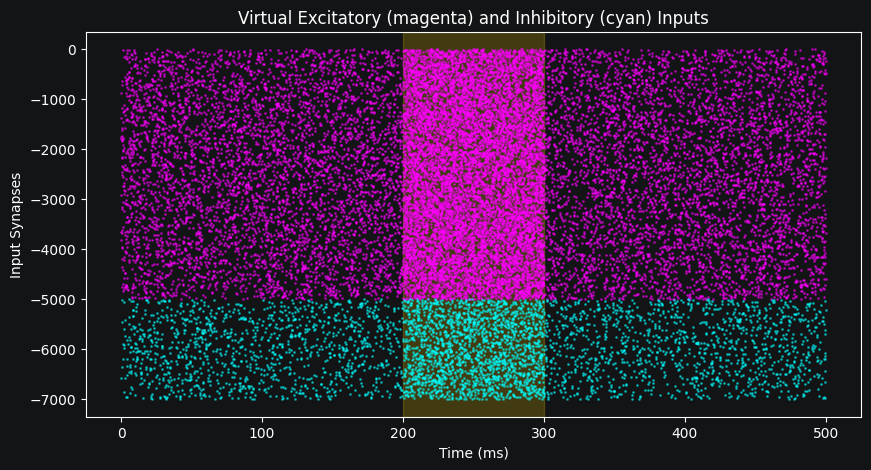

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, (stim, syn, con, spike_vec) in enumerate(exc_background):
    spikes = spike_vec.to_python()
    ax.plot(spikes, np.ones_like(spikes) - i, '.', color='magenta', markersize=2, alpha=0.5)
for i, (stim, syn, con, spike_vec) in enumerate(inh_background):
    spikes = spike_vec.to_python()
    ax.plot(spikes, np.ones_like(spikes) - i - len(exc_background), '.', color='cyan', markersize=2, alpha=0.5)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Input Synapses')
ax.set_title('Virtual Excitatory (magenta) and Inhibitory (cyan) Inputs')
ax.axvspan(200, 300, alpha=0.2, color='gold');

### Within-Network Connections

Next, we will define synaptic connections between the biophysical neurons within our network. We will use a connection probability of `p_connect = 0.3`, meaning each pair of neurons has a 30% chance of being connected.

In [ ]:
netcons = []
synapses = []
conn_matrix = np.zeros((n_cells, n_cells))
p_connect = 0.3

for pre in range(n_cells):
    for post in range(n_cells):
        if pre != post and random.random() < p_connect:
            segments = [seg for sec in cells[post].all for seg in sec]
            seg = random.choice(segments)
            syn = h.ExpSyn(seg)
            syn.tau = 2.0
            syn.e = 0.0
            weight = 0.005

            con = h.NetCon(seg._ref_v, syn, sec=seg.sec)
            con.threshold = -20
            con.weight[0] = weight
            con.delay = 2.0

            synapses.append(syn)
            netcons.append(con)
            conn_matrix[pre, post] = 1

We can visualize both the network topology as a graph and the connectivity matrix of our biophysical neurons. Note that virtual connections are not displayed in these visualizations.

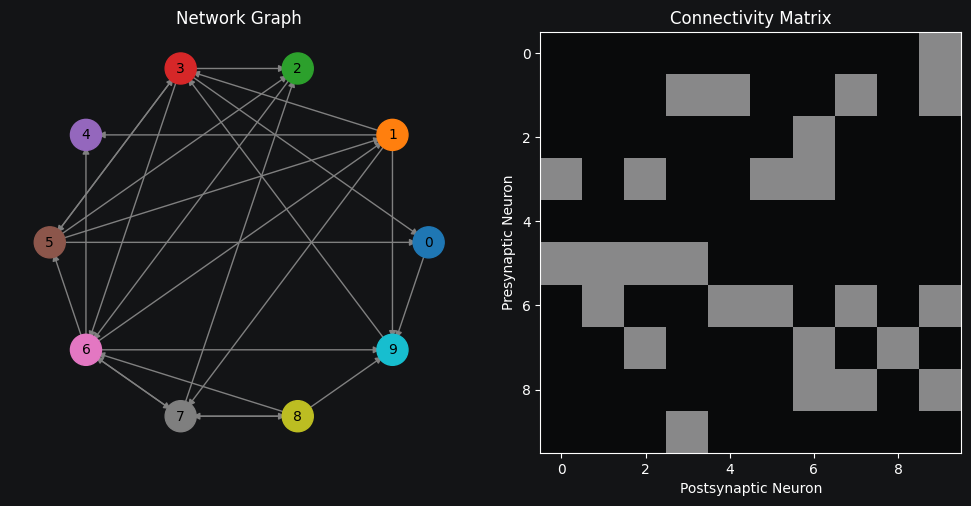

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# 1. Network graph
G = nx.DiGraph()
node_colors = [f'C{i}' for i in range(n_cells)]
for i in range(n_cells):
    G.add_node(i, color=node_colors[i])
for pre in range(n_cells):
    for post in range(n_cells):
        if conn_matrix[pre, post]:
            G.add_edge(pre, post)

pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax[0], node_color=[node[1]['color'] for node in G.nodes(data=True)], node_size=500)
nx.draw_networkx_edges(G, pos, ax=ax[0], edge_color='gray')
nx.draw_networkx_labels(G, pos, ax=ax[0], font_size=10)
ax[0].set_title('Network Graph')
ax[0].axis('off')

# 2. Connectivity matrix
im = ax[1].imshow(conn_matrix, cmap='Greys_r', aspect='equal', vmin=-0, vmax=1, alpha=0.5)
ax[1].set_xlabel('Postsynaptic Neuron')
ax[1].set_ylabel('Presynaptic Neuron')
ax[1].set_title('Connectivity Matrix');

plt.tight_layout()

## Simulation

To analyze network behavior, we need to record relevant variables from our simulation. We will:

- Record somatic membrane voltage from all cells
- Implement spike detection for somatic action potentials

In [ ]:
detectors = []
spike_times = h.Vector()
spike_gids = h.Vector()
for i, cell in enumerate(cells):
    spike_detector = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec=cell.soma[0])
    spike_detector.threshold = -20
    spike_detector.record(spike_times, spike_gids, i)
    detectors.append(spike_detector)

recordings = [h.Vector() for _ in cells]
for i, cell in enumerate(cells):
    recordings[i].record(cells[i].soma[0](0.5)._ref_v)

t = h.Vector()
t.record(h._ref_t)

Vector[7012]

With our recording setup complete, we are ready to run the simulation.

In [16]:
run(500, temperature=37, v_init=-65)

## Results

Now we can examine the simulation outcomes through several complementary visualizations:

1. We will display again the raster plot showing the timing of virtual excitatory and inhibitory inputs throughout the simulation.

2. We will plot the somatic voltage recordings from all biophysical neurons to observe their individual responses to the varying input conditions.

3. We will create a raster plot of detected spikes from our biophysical neurons.

4. Finally, we will calculate and plot the instantaneous firing rate of the entire population of biophysical neurons to quantify the overall network response to the changing background input.

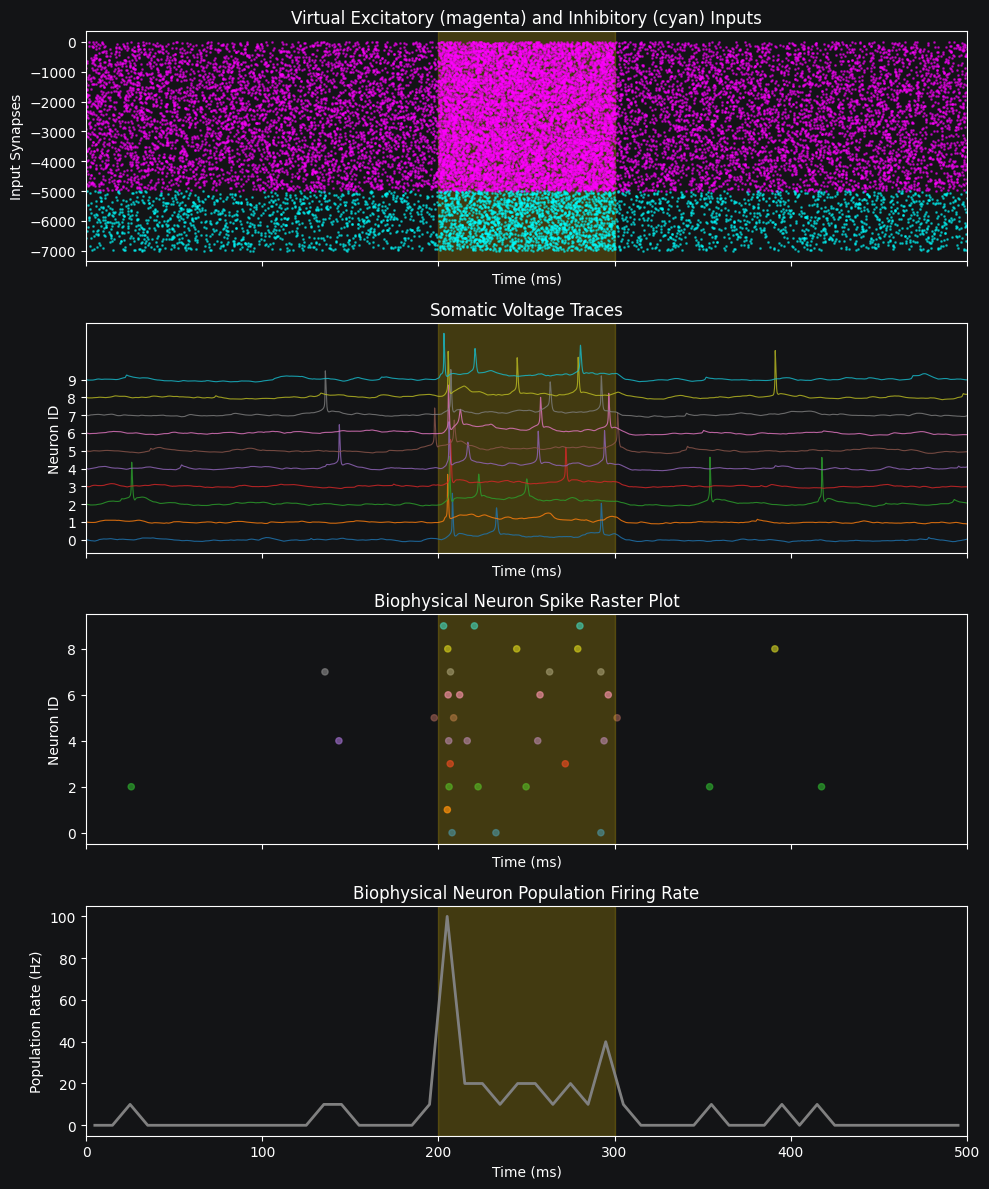

In [ ]:
time_array = np.array(t)
spike_times_array = np.array(spike_times) if spike_times.size() > 0 else np.array([])
spike_gids_array = np.array(spike_gids) if spike_gids.size() > 0 else np.array([])

fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 1. Virtual Input Spikes
for i, (stim, syn, con, spike_vec) in enumerate(exc_background):
    spikes = spike_vec.to_python()
    ax[0].plot(spikes, np.ones_like(spikes) - i, '.', color='magenta', markersize=2, alpha=0.5)
for i, (stim, syn, con, spike_vec) in enumerate(inh_background):
    spikes = spike_vec.to_python()
    ax[0].plot(spikes, np.ones_like(spikes) - i - len(exc_background), '.', color='cyan', markersize=2, alpha=0.5)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input Synapses')
ax[0].set_title('Virtual Excitatory (magenta) and Inhibitory (cyan) Inputs')
ax[0].axvspan(200, 300, alpha=0.2, color='gold');

# 2. Somatic Voltage Traces
for i, cell in enumerate(cells):
    offset = i * 40  # 40 mV spacing
    ax[1].plot(time_array, np.array(recordings[i]) + offset, color=f'C{i}', linewidth=0.8, alpha=0.8)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neuron ID')
ax[1].set_title('Somatic Voltage Traces')
ax[1].set_yticks(np.arange(n_cells) * 40 - 65)
ax[1].set_yticklabels([str(i) for i in range(n_cells)])
ax[1].set_xlim([0, 500])
ax[1].axvspan(200, 300, alpha=0.2, color='gold');

# 3. Spike Raster Plot
ax[2].scatter(spike_times_array, spike_gids_array, c=[f'C{int(gid)}' for gid in spike_gids_array], s=20, alpha=0.7)
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('Neuron ID')
ax[2].set_title('Biophysical Neuron Spike Raster Plot')
ax[2].set_ylim(-0.5, n_cells - 0.5)
ax[2].axvspan(200, 300, alpha=0.2, color='gold')

# 4. Population Firing Rate
bin_size = 10  # ms
bins = np.arange(0, t[-1] + bin_size, bin_size)
hist, _ = np.histogram(spike_times_array, bins)
rate = hist / (bin_size / 1000) / n_cells
ax[3].plot(bins[:-1] + bin_size / 2, rate, color='gray', linewidth=2)
ax[3].set_xlabel('Time (ms)')
ax[3].set_ylabel('Population Rate (Hz)')
ax[3].set_title('Biophysical Neuron Population Firing Rate')
ax[3].axvspan(200, 300, alpha=0.2, color='gold', label='Stimulation')
plt.tight_layout()

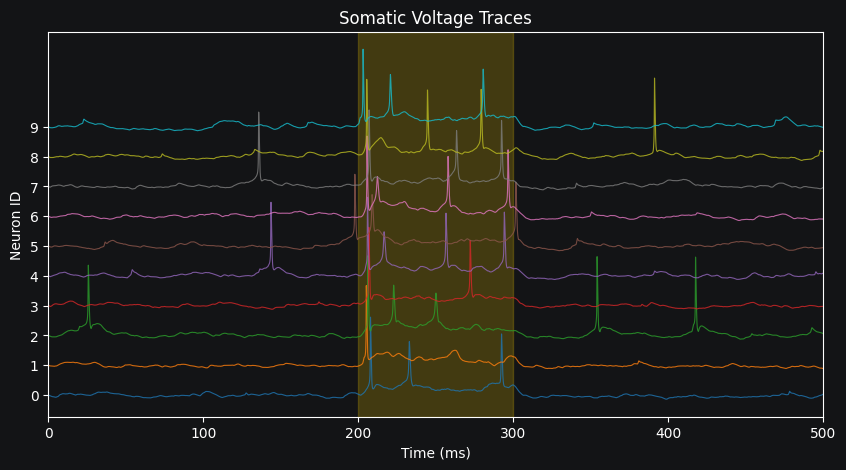

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, cell in enumerate(cells):
    offset = i * 40  # 40 mV spacing
    ax.plot(time_array, np.array(recordings[i]) + offset, color=f'C{i}', linewidth=0.8, alpha=0.8)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron ID')
ax.set_title('Somatic Voltage Traces')
ax.set_yticks(np.arange(n_cells) * 40 - 65)
ax.set_yticklabels([str(i) for i in range(n_cells)])
ax.set_xlim([0, 500])
ax.axvspan(200, 300, alpha=0.2, color='gold');

In this tutorial, we demonstrated how to:

- export a model from DendroTweaks,

- integrate it into a custom network built in NEURON,

- add background inputs and recurrent connectivity,

- record and analyze simulation results.

Although the example network is highly simplified, the workflow can be adapted to build more realistic circuits. By adjusting the connectivity rules, input statistics, or neuron types, one can gradually increase the biological fidelity of the model.